## Problem Statement

Photos team is interested in understanding their user base. To help explore this question,
we have provided a sample dataset* of Photos App users. The dataset includes their feature 
usage as well as related information about the user and their device. All usage activity
in the dataset is aggregated over a month for each user.
We would like for you to use this data to help the team understand the different types of 
Photos app users and insights about the user segments that were found.

### Objective of Analysis

* Understanding Numerical and categorical variables 
* Understanding General userers feature usage, special users and heavy users
* Finding similarities between product features by usage
* Finding clusters between users
* Is it possible to predict a new user's future behavior from their initial information ?

### Contents of Analysis

* Priliminary  Exploratory Data Analysis (EDA)
    * Import required modules and load data
    * Just making sure uniqueness of primery key
    * Checking for missing values
    * Let's analyse Categorical features
    * Modifying CountryShortName
    * Modifying MostUsedPhotoApps
    * Let's check Numerical variables
* Features usage by Users category
    * Features usage by all users
    * Special or Advanced features/users
    * Heavy Users/Outliers
    * Are outliers and special users are same ? Or what is the intersection ?
* Similarity between features
    * Content based similarity for special features based on product usage
    * Content Similarity for all numeric features
    * Factor Analysis to see if we can get some insights about factors
    * User based similarity using KNN
* Clustering and prediction for new users
    * How is the behavior of Outliers or Special Users different then general users ?
    * Is it possible to predict General or Special category before users start using product?
    * Try cluster for all users
    * PCA followed by K-means clustering
    * Cluster using Gaussian Mixture
    * Classification model where target values are GMM clusters
    * How the target values are different for numerical variables
    * Let's see categorical variables with target
    * Let's try building models
* Conclusion 

#### Priliminary Exploratory Data Analysis (EDA)

#### Import required modules and load data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import itertools
from scipy import linalg
from sklearn import mixture
from matplotlib.colors import LogNorm
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA

In [2]:
file_path="/Users/krishanubanerjee/Documents/microsoft/"
    
df_photos_user=pd.read_csv(file_path+"PhotosUserProfile.csv",encoding = "ISO-8859-1")

In [3]:
df_photos_user.head()

,UserId,CountryShortName,IsTouchEnabled,FormFactor,NumberOfActiveDaysInPhotosApp,TotalLaunchCount,LaunchViaCropPicker,LaunchViaWindowsCameraRoll,LaunchViaLumiaCameraRoll,LaunchViaStorageSense,...,NumberOfRichMedia,TotalFilesInCollection,AgeGroup,Gender,NumberOfActiveDaysInOS,TotalTimeInAllAppsInMins,TotalTimeInAllPhotosAppsInMins,MostUsedPhotoApp,TotalTimeInPhotosAppInMins,TotalTimeInOtherPhotosAppsInMins
0,1,Bangladesh,False,NaN,1,2,0,0,0,0,...,0,1,NaN,NaN,16,3713,1,Photos,1,0.0
1,2,Ukraine,False,Notebook,2,3,0,0,0,0,...,0,175,[25-35),M,30,8740,1203,App116,0,1203.0
2,3,China,False,Desktop,1,1,0,0,0,0,...,0,5,NaN,NaN,28,12811,0,Photos,0,NaN
3,4,Slovakia,False,Notebook,2,5,0,0,0,0,...,0,196,>=50,M,16,1489,6,Photos,6,0.0
4,5,Morocco,False,Notebook,5,8,0,0,0,0,...,0,71,NaN,NaN,30,12296,17,Photos,8,8.0


In [4]:
len(df_photos_user)

71696

##### Just making sure uniqueness of primery key

In [5]:
[list(df_photos_user.columns)[i] for i in range(len(list(df_photos_user.columns))) \
                     if df_photos_user[list(df_photos_user.columns)[i]].nunique()==df_photos_user.shape[0]]

['UserId']

##### Checking for missing values

In [6]:
cols=list(df_photos_user.columns)
for col in cols:
    missing_prcntg=round(df_photos_user[col].isnull().sum()/len(df_photos_user),2)
    if missing_prcntg > 0 :
        print (col+' - '+str(missing_prcntg))

FormFactor - 0.01
FinalOneDriveSettingState - 0.99
FinalDuplicateSettingState - 1.0
FinalEnhanceSettingState - 1.0
AgeGroup - 0.5
Gender - 0.54
TotalTimeInOtherPhotosAppsInMins - 0.49


<br> We can see three fields are completely missing (99% to 100%). We have to drop these fields for the rest of our analysis
<br> 'AgeGroup' and 'Gender' have almost 50% missing values. We need to apply some missing value  imputation for these fields

#### Let's analyse Categorical features

In [7]:
def categorical_eda(df, hue=None):
    """Given dataframe, generate EDA of categorical data
    Arguments - 
        df - given data frame 
        hue - color argument
    Returns -
        Count distribution of categorical variables (defined before)
    """
    # Plot count distribution of categorical data
    for col in list(categorical_features):
        fig = sns.catplot(x=col, kind="count", data=df, hue=hue)
        fig.set_xticklabels(rotation=90)
        plt.show()

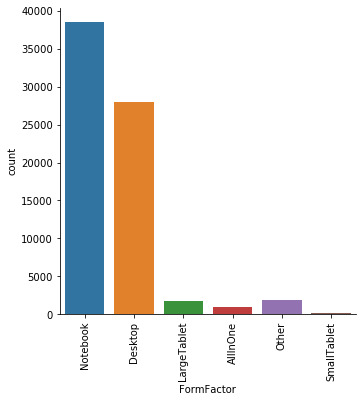

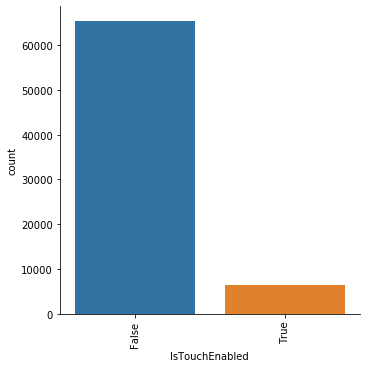

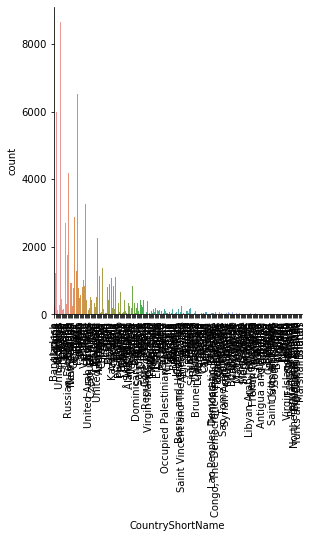

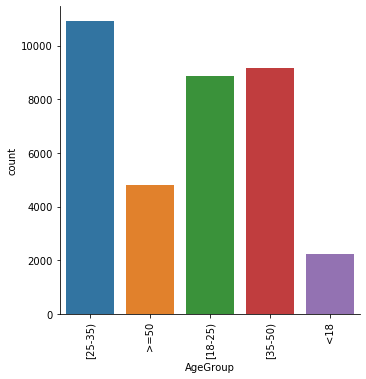

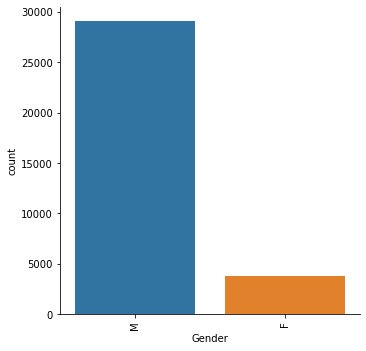

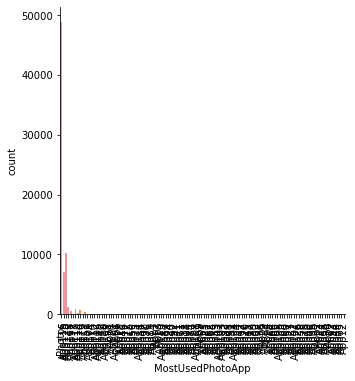

In [8]:
cols=list(set(df_photos_user.columns)
        -{'FinalOneDriveSettingState','FinalDuplicateSettingState','FinalEnhanceSettingState'})
categorical_features=[cols[i] for i in range(len(cols)) \
                     if (df_photos_user[cols[i]].dtypes!='float64')&(df_photos_user[cols[i]].dtypes!='int64')]
categorical_eda(df_photos_user, hue=None)

* Form 'AgeGroup' we can see highest number of users from age group 25-35, 
  followed by 35-50 and 18-25. this is very expected result
* 'TouchEnable' is mostly false
* 'Notebook' and 'Desktop' have highest number of users in 'FormFactor'
* Number of 'M' users are much higher than 'F'. Not sure why ? Or it is because of missing data
* Too many values for 'CountryShortName' and 'MostUsedPhotoApp'. 
* Let's create a policy . If user count is less than 1% for the categories we are assigning 
    into another category 'Others'


##### Modifying CountryShortName 

In [9]:
df_cntry_lkp=(df_photos_user['CountryShortName'].value_counts(normalize=True)>.01)\
                .reset_index()
df_cntry_lkp=df_cntry_lkp[df_cntry_lkp['CountryShortName']==True]

In [10]:
df_photos_user['Country_modified']=np.where(df_photos_user['CountryShortName'].isin(df_cntry_lkp['index']),
             df_photos_user['CountryShortName'],'Other')

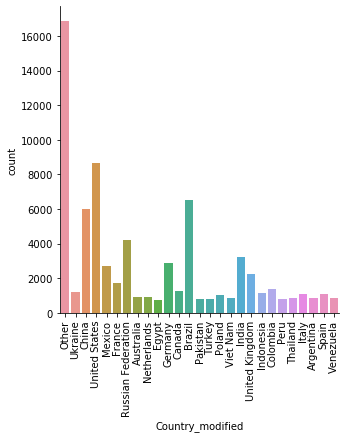

In [11]:
fig = sns.catplot(x='Country_modified', kind="count", data=df_photos_user)
fig.set_xticklabels(rotation=90)
plt.show()

* We can see highest number of users from USA, followed by Brazil,China,Russian Federation,
  India and UK. Others countries (with > 1%) have around 1000 users 
* But if we combine all small countries with less than 1% individual users then their 
  aggregate value is almost 25% of the total users.In real world, 
    based on business/product requirement, we can create sub-class like 'Asian-others','African-others' etc.
    

#### Modifying MostUsedPhotoApps

In [12]:
df_photo_lkp=(df_photos_user['MostUsedPhotoApp'].value_counts(normalize=True)>.01)\
                .reset_index()
df_photo_lkp=df_photo_lkp[df_photo_lkp['MostUsedPhotoApp']==True]

In [13]:
df_photos_user['photo_modified']=np.where(df_photos_user['MostUsedPhotoApp'].isin(df_photo_lkp['index']),
             df_photos_user['MostUsedPhotoApp'],'Other')

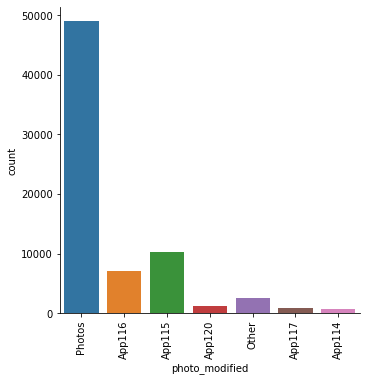

In [14]:
fig = sns.catplot(x='photo_modified', kind="count", data=df_photos_user)
fig.set_xticklabels(rotation=90)
plt.show()

<br> Almost 70% of the users use Photos

#### Let's check Numerical variables

In [15]:
def numeric_eda(df, hue=None):
    """Given dataframe, generate Distribution of of numeric data
    This function will give an idea of numerical data and can be extended for any
    numerical variables
    Arguments -
        df - given data frame 
        hue - color argument
    Returns -
        Boxplot for distribution and description (mean,std,quartile,min,max) for numerical variables (defined before)
    """
    display(df.describe().T)
    columns = df.select_dtypes(include=np.number).columns
    figure = plt.figure(figsize=(20, 10))
    figure.add_subplot(1, len(columns), 1)
    for index, col in enumerate(columns):
        if index > 0:
            figure.add_subplot(1, len(columns), index + 1)
        sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
    figure.tight_layout()
    plt.show()

In [16]:
numerical_features=[cols[i] for i in range(len(cols)) \
                     if ((df_photos_user[cols[i]].dtypes=='float64')|(df_photos_user[cols[i]].dtypes=='int64'))]
numerical_features=list(set(numerical_features)-{'UserId'})

The following command can be used for any numerical features. Here showing some of them

,count,mean,std,min,25%,50%,75%,max
NumberOfImages,71696.0,1369.763962,4667.959965,0.0,7.00,80.0,794.0,178747.0
ImageEdit,71696.0,0.859406,12.837967,0.0,0.00,0.0,0.0,2912.0
TotalTimeInAllPhotosAppsInMins,71696.0,83.271870,437.281809,0.0,1.00,8.0,36.0,11470.0
LaunchByProtocol,71696.0,0.103813,1.824454,0.0,0.00,0.0,0.0,290.0
TotalTimeInAllAppsInMins,71696.0,7818.248005,27560.108312,1.0,1526.75,3726.0,7537.0,623279.0
ShareSessions,71696.0,0.110536,1.716479,0.0,0.00,0.0,0.0,414.0


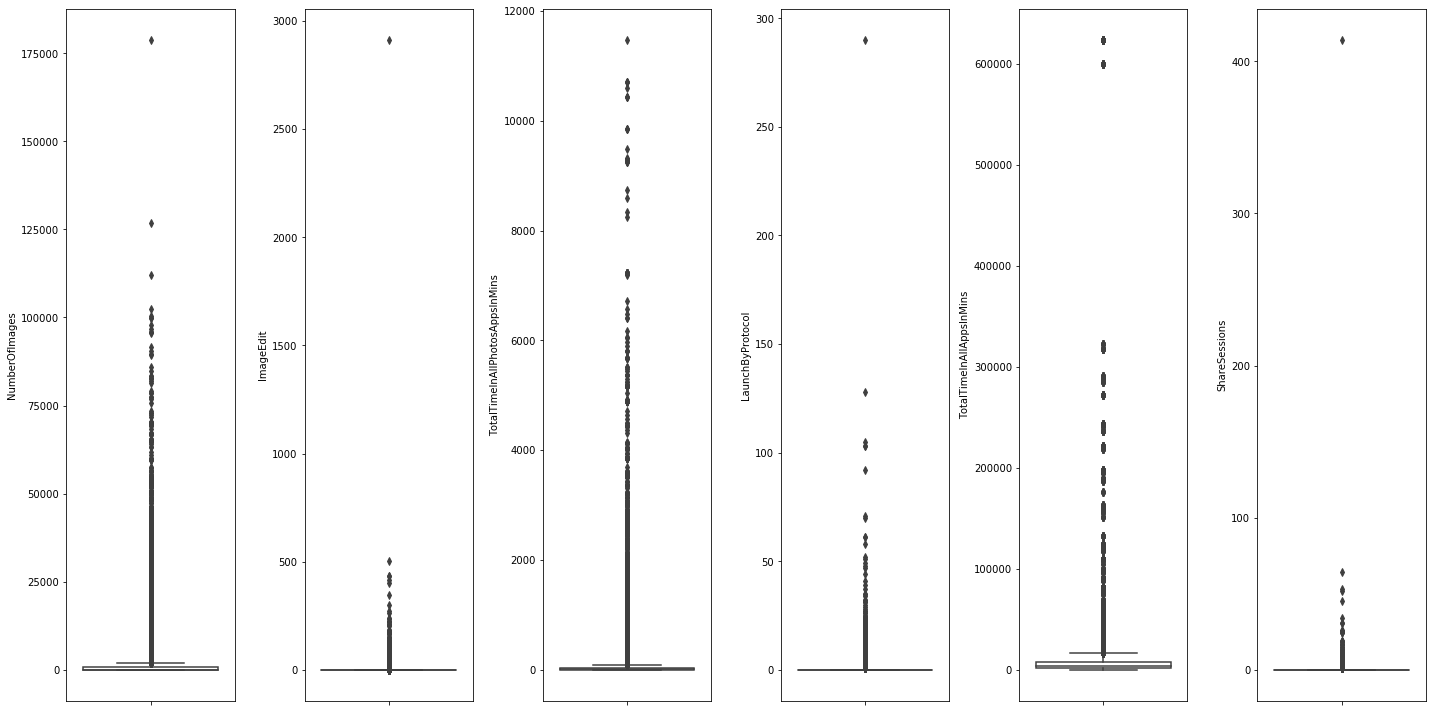

In [141]:
numeric_eda(df_photos_user[numerical_features[0:6]])

* There are some fields where all values are zero. Let's exclude these fields

In [18]:
col_to_exclude=[]
for col in numerical_features:
    if (df_photos_user[col].mean()==0)& (df_photos_user[col].std()==0):
        col_to_exclude.append(col)

In [19]:
col_to_exclude

['LaunchBySearch', 'LaunchViaLumiaCameraRoll', 'LaunchViaDrmViewer']

* There are some fields where distribution is very skewed and almost 90% of the users
    don't use these fields. 
* Let's check what are those fields and how many users using them.

In [20]:
numerical_features=list(set(numerical_features)-set(col_to_exclude))

<BarContainer object of 37 artists>

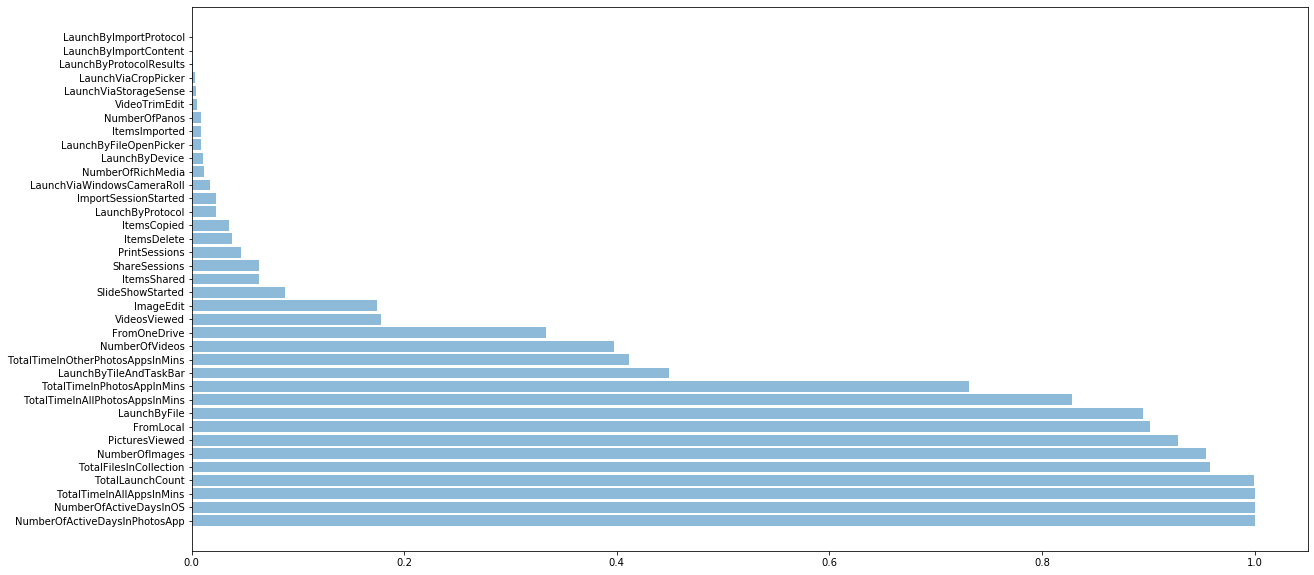

In [121]:
df_user_count=pd.DataFrame({numerical_features[i]:df_photos_user['UserId'][df_photos_user[numerical_features[i]]>0].count()/len(df_photos_user)
        for i in range(len(numerical_features))}.items(),columns=['Features','user_count'])\
        .sort_values(by='user_count',ascending=False)
plt.figure(figsize=(20,10))
plt.barh(df_user_count['Features'],df_user_count['user_count'],align='center', alpha=0.5)

The above result is interesting 
* There are twenty features used by less than 10% of the users. These features may be any special
    features or advance features or people are not liking or not getting attention for some reason . 
    We will study these features and users in depth
* There are ten features used by more than 80% of the users. We will also analyse these features for all users

#### Features usage by Users category

#### Features usage by all users

mean product used :12.600131109127426
standard deviation of product used :2.352792450305386


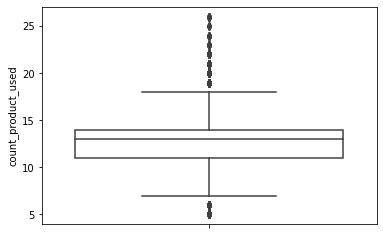

In [379]:
df_usage=df_photos_user[list({'UserId'}|set(numerical_features))]
df_usage=df_usage.set_index('UserId')
df_usage_sum=pd.DataFrame(zip(df_usage.index,list((df_usage>0).sum(axis=1))),columns=['UserId','count_product_used'])
print('mean product used :'+str(df_usage_sum['count_product_used'].mean()))
print('standard deviation of product used :'+str(df_usage_sum['count_product_used'].std()))
sns.boxplot(y='count_product_used', data=df_usage_sum, boxprops={'facecolor': 'None'})

In [383]:
Q1 = df_usage_sum['count_product_used'].quantile(0.25)
Q2 = df_usage_sum['count_product_used'].quantile(0.5)
Q3 = df_usage_sum['count_product_used'].quantile(0.75)
IQR = Q3 - Q1

In [395]:
print('number of users above upper bound :'+str(len(df_usage_sum[df_usage_sum['count_product_used']>(Q3+1.5*IQR)])))
print('number of users above Q3 and below upper bound :'+\
              str(len(df_usage_sum[(df_usage_sum['count_product_used']>=Q3)&\
                                    (df_usage_sum['count_product_used']<(Q3+1.5*IQR))])))
print('number of users above Q2 and below Q3 bound :'+\
              str(len(df_usage_sum[(df_usage_sum['count_product_used']>=Q2)&\
                                    (df_usage_sum['count_product_used']<Q3)])))
print('number of users above Q1 and below Q2 bound :'+\
              str(len(df_usage_sum[(df_usage_sum['count_product_used']>=Q1)&\
                                    (df_usage_sum['count_product_used']<Q2)])))
print('number of users below Q1 and above lower bound :'+\
              str(len(df_usage_sum[(df_usage_sum['count_product_used']>=(Q1-1.5*IQR))&\
                                    (df_usage_sum['count_product_used']<Q1)])))
print('number of users below lower bound :'+\
              str(len(df_usage_sum[(df_usage_sum['count_product_used']<(Q1-1.5*IQR))])))

number of users above upper bound :1009
number of users above Q3 and below upper bound :21931
number of users above Q2 and below Q3 bound :13642
number of users above Q1 and below Q2 bound :22911
number of users below Q1 and above lower bound :11783
number of users below lower bound :420


* We can see on average users use 12 features and also we can see their quantiles
* There are 1009 users use more than quantile upper bound. They are definitely heavy users
* Only 420 users use less than 7 features. As a whole the product usage is good

##### Special or Advanced features/users

In [22]:
skewed_cols=[]
for col in numerical_features:
    if (np.percentile(df_photos_user[col],90)==0):
        skewed_cols.append(col)

In [122]:
len(skewed_cols)

20

In [23]:
special_users=[]
for col in skewed_cols:
    special_users.extend(list(df_photos_user['UserId'][df_photos_user[col] !=0]))

In [24]:
len(set(special_users))

19020

In [25]:
len(set(special_users))/len(df_photos_user)

0.2652867663467976

* We can see around 26% of the users use these features.We want to know if there is any similarity exists between these features. That can be very useful for product recommendation

In [293]:
df_special=df_photos_user[list({'UserId'}|set(skewed_cols))][df_photos_user['UserId'].isin(special_users)]
df_special=df_special.set_index('UserId')

<BarContainer object of 10 artists>

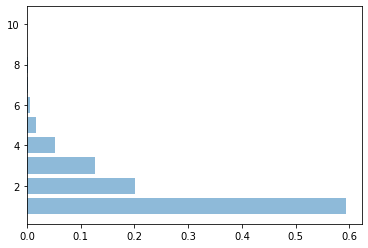

In [302]:
df_agg=pd.DataFrame(zip(df_special.index,list((df_special>0).sum(axis=1))),\
                        columns=['UserId','count_special_features'])
df_agg=df_agg.groupby('count_special_features').agg({'UserId':'size'}).reset_index()
df_agg['UserId']=round(df_agg['UserId']/len(df_special),4)
plt.barh(df_agg['count_special_features'],df_agg['UserId'],align='center', alpha=0.5)

* We can see 60% of the users only use one particular special features. 20% of them use two of the special features.
    10% of them use three of the special features and so on.

#### Heavy Users/Outliers

* We have seen from box plots of numerical variables, there are some outliers.
    Outliers are not bad in this case. Outliers are heavy users of the applications
* Here heavy users/outliers are defined when z-score for any feature is more than 3.

In [368]:
df_outlier=df_photos_user[list({'UserId'}|set(numerical_features))]
df_outlier=df_outlier.set_index('UserId')
df_outlier=pd.DataFrame(np.abs(stats.zscore(df_outlier)))
df_outlier=pd.DataFrame(zip(df_outlier.index,list((df_outlier>3).sum(axis=1))),columns=['UserId','count_outlier'])
df_outlier=df_outlier[df_outlier['count_outlier']>0]
print(len(df_outlier))

10154


<BarContainer object of 11 artists>

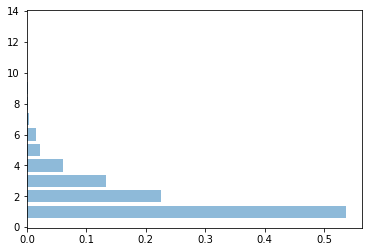

In [369]:
df_outlier_agg=df_outlier.groupby('count_outlier').agg({'UserId':'size'}).reset_index()
df_outlier_agg['UserId']=round(df_outlier_agg['UserId']/len(df_outlier),4)
plt.barh(df_outlier_agg['count_outlier'],df_outlier_agg['UserId'],align='center', alpha=0.5)

* 10154 users are outliers/heavy users for at least one features.
* More than 50% of these users outliers for one users. Rest of them outliers for more than one features

##### Are outliers and special users are same ? Or what is the intersection ?

In [398]:
special_or_outlier_user=list(set(outlier_users)|set(special_users))
special_and_outlier_user=set(outlier_users).intersection(set(special_users))
only_special_user=len(special_or_outlier_user)-len(set(outlier_users))
only_outlier_user=len(special_or_outlier_user)-len(set(special_users))

In [399]:
print('Outlier or Special Users :'+str(len(special_or_outlier_user)))
print('Outlier and Special Users :'+str(len(special_and_outlier_user)))
print('Special Users Not Outliers :'+str(only_special_user))
print('Outliers Not Special Users :'+str(only_outlier_user))

Outlier or Special Users :23088
Outlier and Special Users :6086
Special Users Not Outliers :12934
Outliers Not Special Users :4068


* There is significant overlap between these two categories

#### Similarity between features

##### Content based similarity for special features based on product usage

In [26]:
def cosine_sim(u, v):
    """
    Cosine similarity reflects the degree of similarity between u and v  
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)
    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    
    distance = 0.0
    dot = np.dot(u,v)
    # Compute the L2 norm 
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    # Compute the cosine similarity 
    cosine_similarity = dot/(norm_u*norm_v)
    
    return cosine_similarity

In [27]:
df_special_rare=df_photos_user[df_photos_user['UserId'].isin(special_users)]
df_special_rare=df_special_rare[skewed_cols].fillna(0)
transformer = preprocessing.RobustScaler().fit(df_special_rare)
feature_transformer = transformer.transform(df_special_rare)

In [28]:
special_array=np.zeros((feature_transformer.shape[1],feature_transformer.shape[1]))
for i in range(feature_transformer.shape[1]):
    for j in range(feature_transformer.shape[1]):
        special_array[i][j]=cosine_sim(np.array(feature_transformer[i]),
                  np.array(feature_transformer[j]))

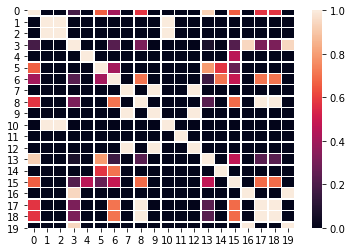

In [29]:
ax = sns.heatmap(special_array, linewidth=0.5)
plt.show()

* We can find similar features from this heat map.
* For example, we can see 'ImportSessionStarted','LaunchViaStorageSense' and 'PrintSessions' are very similar

In [29]:
print(df_special_rare.T.index[1])
print(df_special_rare.T.index[2])
print(df_special_rare.T.index[10])

ShareSessions
LaunchViaCropPicker
ItemsImported


##### Content Similarity for all numeric features

In [46]:
df_features=df_photos_user[numerical_features]
df_features=df_features.fillna(0)
transformer = preprocessing.RobustScaler().fit(df_features)
feature_transformer = transformer.transform(df_features)

In [47]:
feature_array=np.zeros((feature_transformer.shape[1],feature_transformer.shape[1]))
for i in range(feature_transformer.shape[1]):
    for j in range(feature_transformer.shape[1]):
        feature_array[i][j]=cosine_sim(np.array(feature_transformer[i]),
                  np.array(feature_transformer[j]))

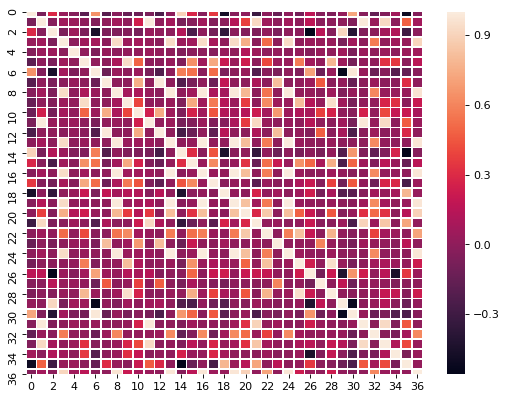

In [48]:
fig=plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = sns.heatmap(feature_array, linewidth=0.5)
plt.show()

* We can see from above heatmap, there are some similarities between some features.
* For example below, we can see feature[3]-'LaunchViaStorageSense' has six similar fetures ( cosine similarity > .9)
    Feature names and similarity values below
* Similarly we can get groupings for other features. This analysis could help to recommend features to the users

In [49]:
np.argwhere((feature_array > .9)&(feature_array < 1))[0:15]

array([[ 1,  1],
       [ 1, 11],
       [ 1, 21],
       [ 1, 31],
       [ 1, 33],
       [ 2, 29],
       [ 3,  8],
       [ 3, 13],
       [ 3, 16],
       [ 3, 19],
       [ 3, 24],
       [ 3, 36],
       [ 5,  5],
       [ 5,  9],
       [ 6,  6]])

In [50]:
df_features.columns[[3,8,13,16,19,24,36]]

Index(['LaunchByProtocol', 'FromOneDrive', 'NumberOfPanos',
       'LaunchByProtocolResults', 'VideoTrimEdit', 'LaunchByImportContent',
       'NumberOfActiveDaysInPhotosApp'],
      dtype='object')

In [51]:
feature_array[3][feature_array[3] > .9]

array([1.        , 0.93662788, 0.93720708, 0.93695831, 0.93552913,
       0.9368485 , 0.9144357 ])

#### Factor Analysis to see if we can get some insights about factors

In [425]:
df_all_users=df_photos_user[list({'UserId'}|(set(numerical_features)-set(skewed_cols)))]
df_all_users=df_all_users.fillna(0)
df_all_users=df_all_users.set_index('UserId')

In [426]:
# Barlett's Test
chi_square_value,p_value=calculate_bartlett_sphericity(df_all_users)
chi_square_value, p_value

(2327003.2578643784, 0.0)

In [427]:
# KMO test
kmo_all,kmo_model=calculate_kmo(df_all_users)
kmo_model

0.5326015071974275

* In this Bartlett ’s test, the p-value is 0. The test was statistically significant, 
  indicating that the observed correlation matrix is not an identity matrix.
* In KMO test the value is less than .6 which is not adequate but still see if we can find anything

In [428]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation=None)
fa.fit(df_all_users, 25)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=3, rotation=None, rotation_kwargs={},
               use_smc=True)

In [429]:
df_factor_analysis=pd.DataFrame(fa.loadings_,columns=['Factor 1','Factor 2','Factor 3'])
df_factor_analysis=df_factor_analysis.set_index(df_all_users.columns)
df_factor_analysis

,Factor 1,Factor 2,Factor 3
NumberOfImages,0.817389,-0.550047,0.259427
ImageEdit,0.077347,0.122718,0.050215
LaunchByFile,0.381685,0.699544,0.344194
NumberOfActiveDaysInOS,0.169735,0.164254,-0.023526
TotalTimeInAllPhotosAppsInMins,0.599328,0.230167,-0.779506
TotalTimeInAllAppsInMins,0.398231,0.118872,-0.473732
TotalTimeInPhotosAppInMins,0.374927,0.280403,-0.175989
LaunchByTileAndTaskBar,0.111661,0.314447,0.131373
FromOneDrive,0.523049,-0.355268,0.088888
NumberOfVideos,0.376345,-0.300311,0.192907


* Factor 1:NumberOfImages/NumberOfActiveDaysInOS/TotalTimeInPhotosAppInMins/FromOneDrive/
    NumberOfVideos/TotalFilesInCollection/FromLocal
* Factor 2:ImageEdit/LaunchByFile/LaunchByTileAndTaskBar/TotalLaunchCount/PicturesViewed/
    VideosViewed/NumberOfActiveDaysInPhotosApp
* Factor 3:TotalTimeInAllPhotosAppsInMins/TotalTimeInAllAppsInMins/TotalTimeInOtherPhotosAppsInMins

In [430]:
fa.get_factor_variance()

(array([3.42637839, 2.92707315, 2.02503218]),
 array([0.20155167, 0.17218077, 0.11911954]),
 array([0.20155167, 0.37373244, 0.49285198]))

* KMO test result was not encouraging. Still we can see three factors. Looks they have some similarity but
factors can be varified with domain knowledge

##### User based similarity using KNN

In [52]:
df_all_users=df_photos_user[list({'UserId'}|(set(numerical_features)-set(skewed_cols)))]
df_all_users=df_all_users.fillna(0)
df_all_users=df_all_users.set_index('UserId')

In [53]:
transformer = preprocessing.RobustScaler().fit(df_all_users)
feature_matrix = transformer.transform(df_all_users)

In [54]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)
model_knn.fit(feature_matrix)
distances, indices = model_knn.kneighbors(feature_matrix)

In [50]:
distances[4]

array([0.        , 0.00149266, 0.0022063 , 0.00236573, 0.00242722,
       0.00248158, 0.00248158, 0.00250678, 0.00257176, 0.00258768])

In [51]:
indices[4]

array([    4, 35110, 23563, 18489, 41021,  2352,  2602, 59887, 47289,
       23795])

* Unsupervised KNN used for user based similarity for 10 nearest neighbours 
* For example,here we can see 10 nearest neighbours  UserId==4 and distances

#### Clustering and Prediction for new users

#### How is the behavior of Outliers or Special Users  different then general users ?

In [401]:
df_photos_user_1=df_photos_user.copy()
df_photos_user_1['user_category']=np.where(df_photos_user['UserId'].isin(special_and_outlier_user),\
                               'Special','General')
df_user_category=df_photos_user_1[['TotalLaunchCount','TotalTimeInAllAppsInMins',\
                                   'NumberOfImages','TotalFilesInCollection',\
                'NumberOfActiveDaysInOS','NumberOfActiveDaysInPhotosApp','user_category']]
df_user_category=df_user_category.fillna(0)

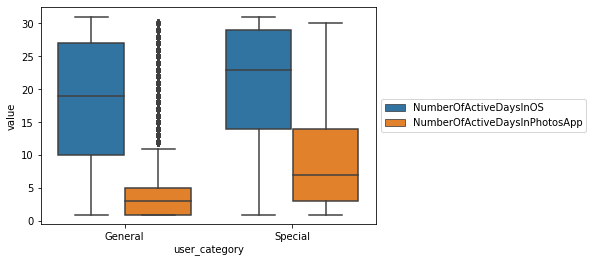

In [402]:
dd=pd.melt(df_user_category,id_vars=['user_category'],value_vars=['NumberOfActiveDaysInOS',\
                                'NumberOfActiveDaysInPhotosApp'],var_name='category')
g=sns.boxplot(x='user_category',y='value',data=dd,hue='category')
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
plt.show()

* We can see Special Users have higher median and 75th percentile than general users which is very much expected

#### Is it possible to predict General or Special category before users start using product?

* Numerical features are basically based on users usage over time. But when users just sign up
    their categorical features are known. Based on categorical features, can we predict they
    will be outlier or special users or general user ?
* Created target column as 1 when outlier or specil users otherwise 0. 
* 'AgeGroup' and "Gender" missing values are replaced by new category 'Unknown'
* Dummy variables are created from Categorical variables 
* Features are converted to numpy array and split to train/test in ratio 80/20
* Base model created with logistic regression and then tried ensemble method with grid search

In [63]:
def get_roc_curve_auc(model,features,labels):
    """ This function will take model, features and prediction labels and
    produce ROC curve with AUC value for train,eval data sets"""
    probs = model.predict_proba(features)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(labels, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [72]:
cols=list(set(df_photos_user.columns)
        -{'FinalOneDriveSettingState','FinalDuplicateSettingState','FinalEnhanceSettingState'})
categorical_features=[cols[i] for i in range(len(cols)) \
                     if (df_photos_user[cols[i]].dtypes!='float64')&(df_photos_user[cols[i]].dtypes!='int64')]

In [73]:
df_model=df_photos_user[{'UserId'}|set(categorical_features)]
df_model=df_model.drop(['CountryShortName','MostUsedPhotoApp'],axis=1)
df_model['target']=np.where(df_model['UserId'].isin(special_and_outlier_user),1,0)
df_model['AgeGroup']=np.where(df_model['AgeGroup'].isna(),'Unknown',df_model['AgeGroup'])
df_model['Gender']=np.where(df_model['Gender'].isna(),'Unknown',df_model['Gender'])
df_model=pd.get_dummies(df_model)

In [74]:
df_model=df_model.set_index(['UserId'])
indices=df_model.index.values
labels = np.array(df_model['target'])
model_features= df_model.drop('target', axis = 1)
model_features = np.array(model_features)
train_features, eval_features, train_labels, eval_labels,idx_train,idx_eval = \
            train_test_split(model_features, labels,indices, test_size = 0.2, random_state = 42)

In [75]:
clf = LogisticRegression(random_state=0).fit(train_features, train_labels)
get_roc_curve_auc(clf,eval_features,eval_labels)

/Users/krishanubanerjee/anaconda3/envs/kaggle_bowl/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


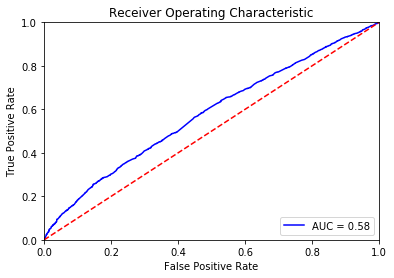

In [76]:
get_roc_curve_auc(clf,eval_features,eval_labels)

In [ ]:
%%time
forest = RandomForestClassifier()
n_estimators = [20,50]
max_depth = [3,5,10,15]
min_samples_split = [2,3,5]
min_samples_leaf = [1,3] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 5, verbose = 1, n_jobs = -1)
bestF = gridF.fit(train_features, train_labels)
print(bestF.best_params_)

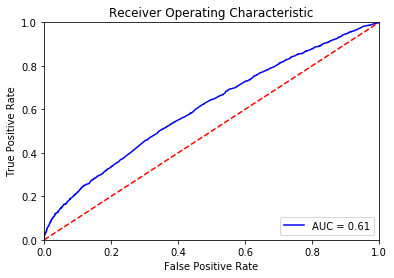

In [82]:
rf_model = RandomForestClassifier(random_state = 1,
                               n_estimators=1000, 
                               max_depth = 15, 
                               min_samples_split = 3,
                               min_samples_leaf = 1)
rf_model.fit(train_features, train_labels)
get_roc_curve_auc(rf_model,eval_features,eval_labels)

##### Try cluster for all users 

* In first attempt K-means clustering with silhouette analysis for all numeric features does not produce any significant clusters. One cluster is taking allmost 95% of the data and rest of the clusters are really small
* Next attempt, density based DBSCAN tried but either getting 50-60 clusters. Otherwise mostly noice
* Next thing tried,PCA followed by K-means clustering. Better than before ,but still very imbalanced
* Gaussian Mixture model atleast give some visual seperation for the clusters

##### PCA followed by K-means clustering

In [405]:
df_all=df_photos_user[list({'UserId'}|(set(numerical_features)-set(col_to_exclude)))]
df_all=df_all.fillna(df_all.mean())
df_all=df_all.set_index("UserId")
transformer = preprocessing.RobustScaler().fit(df_all)
X = transformer.transform(df_all)

In [406]:
# PCA for three components
pca = PCA(n_components=3)
X_r = pca.fit(X).transform(X)
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))


explained variance ratio (first two components): [0.56462848 0.33939796 0.07125825]


Text(0, 0.5, 'PCA 2')

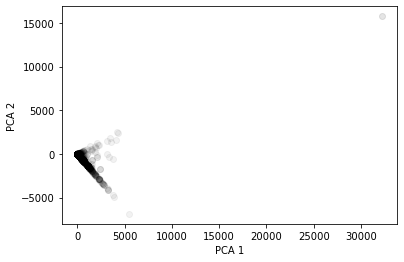

In [407]:
# Let's plot first two components
plt.scatter(X_r[:,0],X_r[:,1],alpha=.05,color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

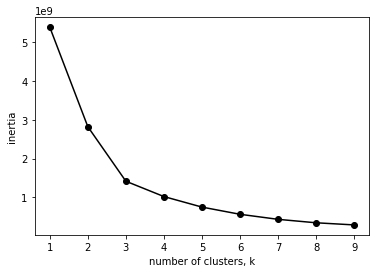

In [408]:
# Find optimum number of clusters using elbow method for PCA components
ks = range(1, 10)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X_r)
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

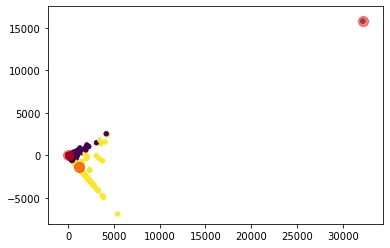

In [409]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10,random_state=0)
pred_y = kmeans.fit_predict(X_r)
plt.scatter(X_r[:,0], X_r[:,1],c=pred_y,s=20, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5)
plt.show()

In [410]:
print(len(pred_y[pred_y==0]))
print(len(pred_y[pred_y==1]))
print(len(pred_y[pred_y==2]))

71284
2
410


##### Cluster using Gaussian Mixture 

In [236]:
#Find the best model with GMMM
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
X=np.array(df_all)
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

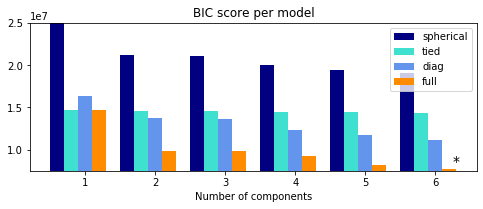

In [237]:
# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

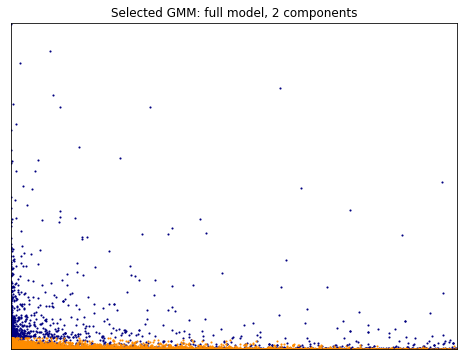

In [414]:
plt.figure(figsize=(8,6))
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = mixture.GaussianMixture(n_components=2,covariance_type='full')
clf.fit(df_all_array)
#splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(df_all_array)
plt.scatter(df_all_array[Y_ == 0, 0], df_all_array[Y_ == 0, 1], 1.2, color='navy')
plt.scatter(df_all_array[Y_ == 1, 0], df_all_array[Y_ == 1, 1], 1.2, color='darkorange')
plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
#plt.subplots_adjust(hspace=.35, bottom=.02)
plt.xlim(0,12000)
plt.ylim(0,300)
plt.show()

In [416]:
print(len(Y_[Y_==0])) ## navy
print(len(Y_[Y_ ==1])) ##orange

11619
60077


#### Classification model where target values are GMM clusters 

In [417]:
df_target=pd.DataFrame(zip(df_all.index,Y_),columns=['UserId','target'])

In [418]:
df_model=df_photos_user[{'UserId'}|set(categorical_features)]
df_model=df_model.drop(['CountryShortName','MostUsedPhotoApp'],axis=1)
df_model=pd.merge(df_model,df_target,on='UserId')
df_model['AgeGroup']=np.where(df_model['AgeGroup'].isna(),'Unknown',df_model['AgeGroup'])
df_model['Gender']=np.where(df_model['Gender'].isna(),'Unknown',df_model['Gender'])

In [419]:
model_col=list(set(df_model.columns)-{'UserId','target'})

#### How the target values are different for numerical variables 

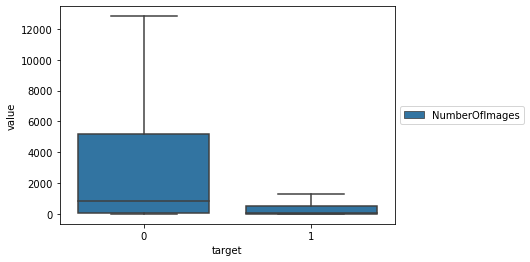

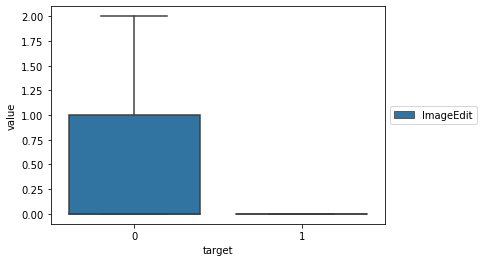

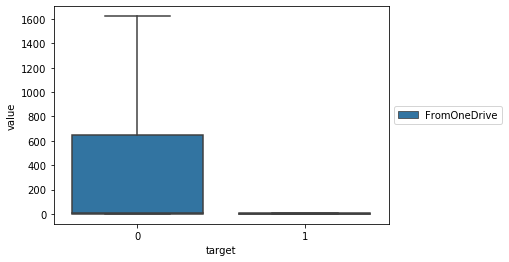

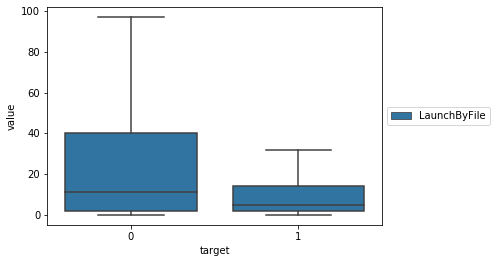

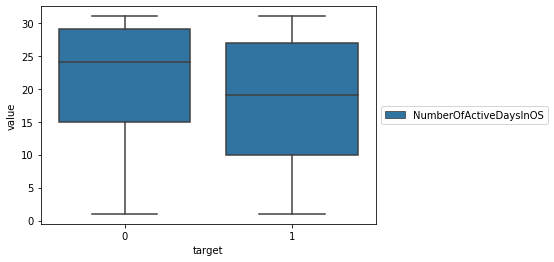

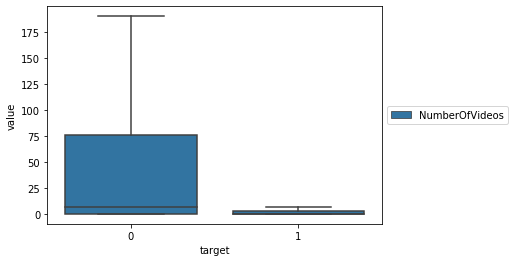

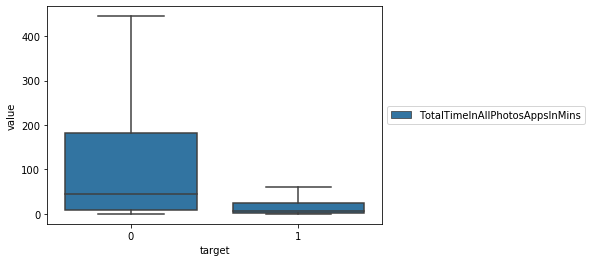

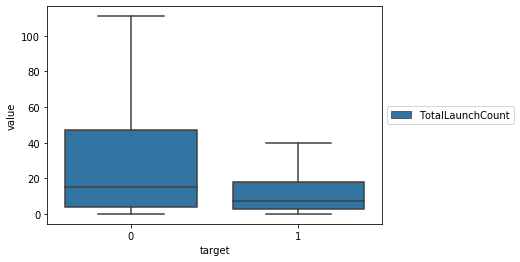

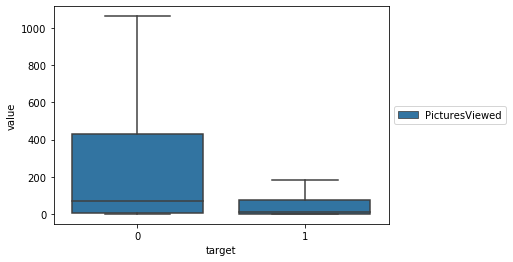

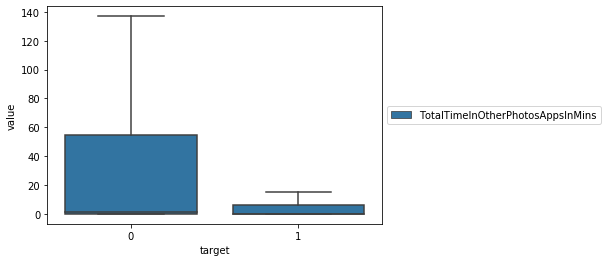

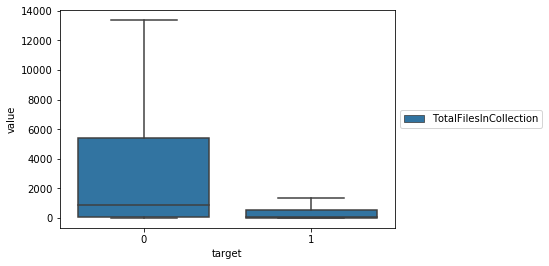

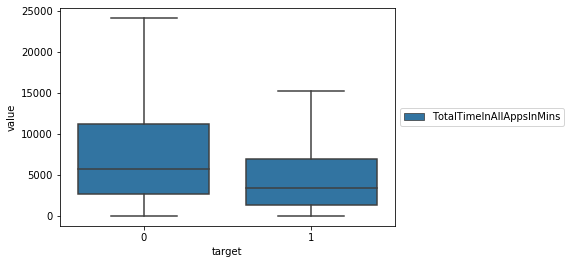

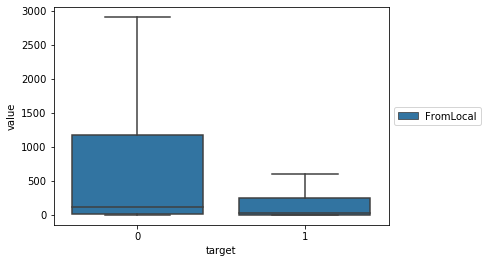

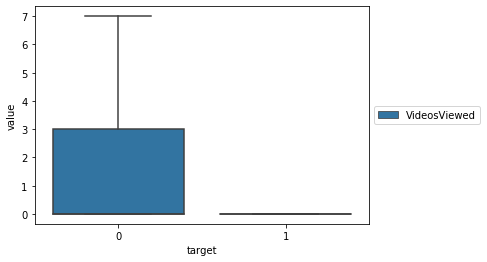

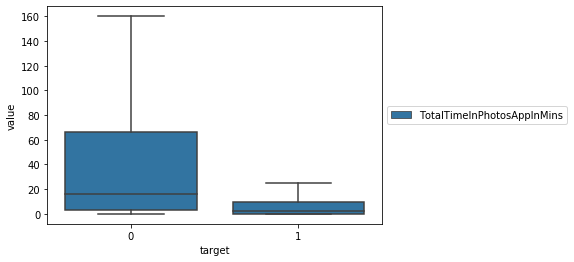

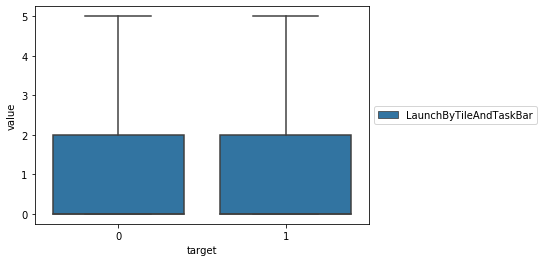

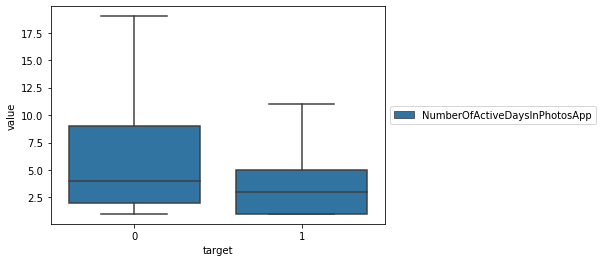

In [424]:
# Excluding outliers
c_palette = ['tab:blue', 'tab:orange']
df_user_category=df_photos_user[list({'UserId'}|set(numerical_features))]
df_user_category=pd.merge(df_user_category,df_target,on='UserId')
df_user_category=df_user_category.fillna(0)
for col in list(set(numerical_features)-set(skewed_cols)):
    dd=pd.melt(df_user_category,id_vars=['target'],value_vars=[col],var_name='category')
    g=sns.boxplot(x='target',y='value',data=dd,hue='category',showfliers = False,palette=c_palette)
    g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    plt.show()

* We can see for most of the variables target range and distributions are different. 

##### Let's see categorical variables with target

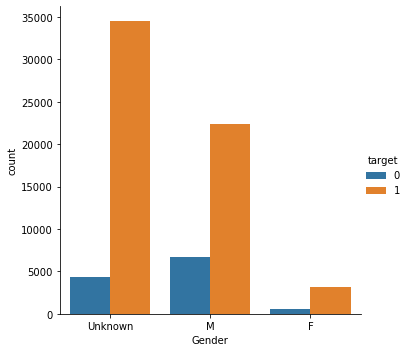

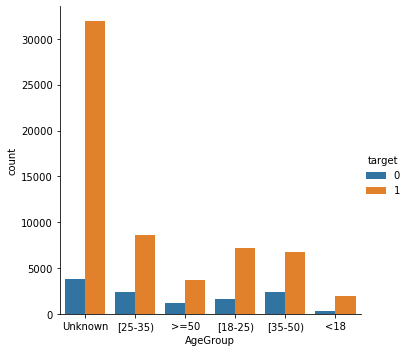

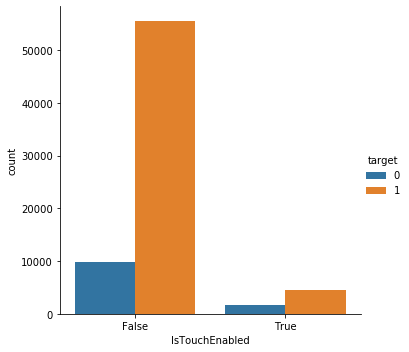

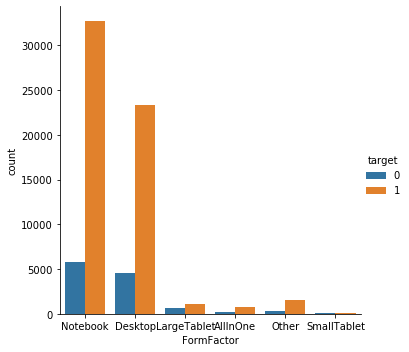

In [421]:
c_palette = ['tab:blue', 'tab:orange']
#sns.countplot(df_model, y='AgeGroup',hue='target',palette=c_palette)
for col in model_col:
    sns.catplot(x=col, kind="count", data=df_model, hue='target',palette=c_palette)
    plt.show()

#### Let's try building models

In [260]:
df_model['AgeGroup']=np.where(df_model['AgeGroup'].isna(),'Unknown',df_model['AgeGroup'])
df_model['Gender']=np.where(df_model['Gender'].isna(),'Unknown',df_model['Gender'])
df_model=pd.get_dummies(df_model)
df_model.shape

(71696, 52)

In [261]:
df_model=df_model.set_index(['UserId'])
indices=df_model.index.values
labels = np.array(df_model['target'])
model_features= df_model.drop('target', axis = 1)
model_features = np.array(model_features)

In [262]:
train_features, eval_features, train_labels, eval_labels,idx_train,idx_eval = \
            train_test_split(model_features, labels,indices, test_size = 0.2, random_state = 42)

/Users/krishanubanerjee/anaconda3/envs/kaggle_bowl/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


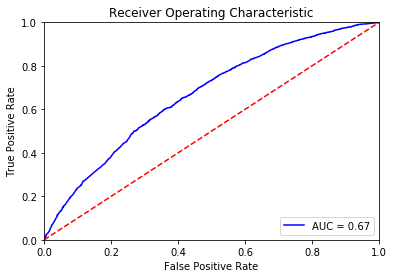

In [263]:
clf = LogisticRegression(random_state=0).fit(train_features, train_labels)
get_roc_curve_auc(clf,eval_features,eval_labels)

In [265]:
%%time
forest = RandomForestClassifier()
n_estimators = [10,25,50,100]
max_depth = [10,15,25]
min_samples_split = [2,3,5]
min_samples_leaf = [1,3] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 5, verbose = 1, n_jobs = -1)
bestF = gridF.fit(train_features, train_labels)
print(bestF.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  7.5min finished


{'max_depth': 25, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}
CPU times: user 48.6 s, sys: 6.02 s, total: 54.6 s
Wall time: 7min 36s


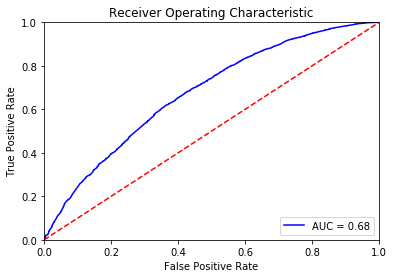

In [267]:
rf_model = RandomForestClassifier(random_state = 1,
                               n_estimators=500, 
                               max_depth = 30, 
                               min_samples_split = 5,
                               min_samples_leaf = 3)
rf_model.fit(train_features, train_labels)
get_roc_curve_auc(rf_model,eval_features,eval_labels)

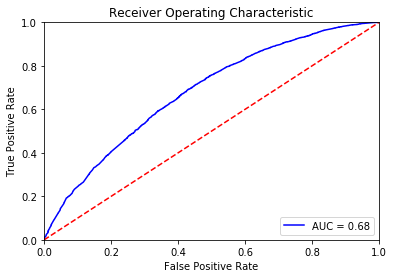

CPU times: user 1min 45s, sys: 244 ms, total: 1min 45s
Wall time: 1min 46s


In [268]:
%%time
xgb_model= XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.8, verbosity=1)

xgb_model.fit(train_features,train_labels)
get_roc_curve_auc(xgb_model,eval_features,eval_labels)

In [289]:
# feature importance
df_top_feature_importance=pd.DataFrame(zip(df_model.columns,xgb_model.feature_importances_),\
                                       columns=['features','importance'])
df_top_feature_importance.sort_values(by='importance',ascending=False).head(10)

,features,importance
48,Gender_F,0.197903
43,AgeGroup_>=50,0.073294
49,Gender_M,0.055030
3,FormFactor_Desktop,0.038440
0,IsTouchEnabled,0.032138
8,photo_modified_App114,0.027257
23,Country_modified_Germany,0.027199
12,photo_modified_App120,0.025162
41,Country_modified_Viet Nam,0.023770
13,photo_modified_Other,0.022047


#### Conclusion 

Many features of this product is widely used. We can see some similarities between features.
Primarily users were categorized by product usage,special feature usage and outliers/heavy users 
for one or multiple features. This categories are used for classification of the users
based on their categorical or initial variables. Accuracy was not that great. Different clustering 
methods tried after that. GMM based cluster results are comperatively resonable. Using this cluster result
as target variable  again classification model tried. In this case result is better than before.
For any new user we can predict user pattern and product usage with 70% accuracy.
In real world this analysis can be extended towards business/product requirement and 
this analysis can help decision making process.